In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from shapes import Point, Rectangle
from environment import Environment2D
from utils import PlotTools
from graph import Graph
from lqr import LQRPlanner
from simulate import Simulator
from search import Plan, NuValues, PlanUtils

import matplotlib.pyplot as plt
import numpy as np
import polytope as pc
from bitarray import bitarray

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [2]:
x_lims = [-10,10]
y_lims = [-5,5]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -6.5,-3,3,5,0)
rec_1 = Rectangle(1, 1,-1,3,3,0)
rec_2 = Rectangle(2, -10,5,20,1,0)
rec_3 = Rectangle(3, -10,-6.5,20,1,0)
rec_4 = Rectangle(4, -2.5,4.5,5,0.5,0)

rec_0.set_error_bounds(np.array([0,0,0,0]), np.array([0,1.5,1.5,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1.5,0]))
rec_2.set_error_bounds(np.array([-0.5,0,0,0]), np.array([0.5,0,0,0]))

rec_0.set_actual_errors(np.array([0,0,1.5,0]))
rec_1.set_actual_errors(np.array([0,0,1.5,0]))
rec_2.set_actual_errors(np.array([-0.5,0,0,0]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3])

<IPython.core.display.Javascript object>


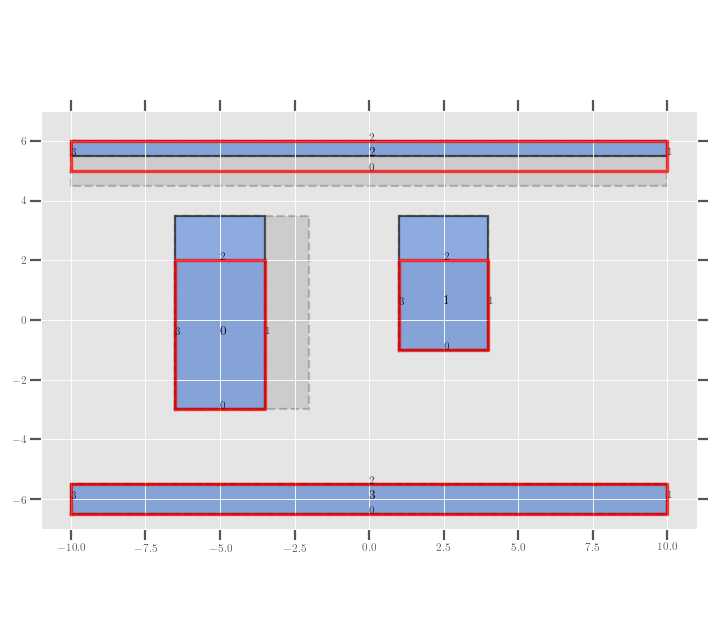

In [3]:
env.plot()

## Test constructor and initialization

In [4]:
x0 = Point(0,0)
lines_seen_now = PlanUtils.get_lines_seen_now(env, x0)
line_indices = PlanUtils.rectlines2lines(lines_seen_now)
print(lines_seen_now)
print(line_indices)

{0: [1], 1: [3]}
[1 7]


In [5]:
plan = Plan(x0, env)
plan.Sn

[array([1, 7])]

In [6]:
print(plan.a.shape)
print(plan.b.shape)
print(plan.e.shape)
print(plan.c.shape)
print(plan.d.shape)
print(plan.p.shape)
print(plan.q.shape)

(2, 2)
(2, 2)
(2, 2)
(2, 2, 100)
(2, 2, 100)
(2, 2, 100)
(2, 2, 100)


In [7]:
print(plan.a)
print(plan.b)
print(plan.e)

[[1. 0.]
 [0. 1.]]
[[0. 0.]
 [0. 0.]]
[[1. 0.]
 [0. 1.]]


In [8]:
print(plan.c[:,:,0])
print(plan.d[:,:,0])
print(plan.p[:,:,0])
print(plan.q[:,:,0])

[[1. 0.]
 [0. 1.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]


In [9]:
print(plan.Nu[0]._nlines)
for key, val in plan.Nu[0]._values.items():
    print(key, end=' ')
    print(val.c, end=' ')
    print(val.G)

2
frozenbitarray('0000000000000000') [-0.75 -0.  ] [0. 0.]
frozenbitarray('0100000000000000') [ 0.75 -0.  ] [0. 0.]
frozenbitarray('0000000100000000') [-0.75  0.  ] [0. 0.]
frozenbitarray('0100000100000000') [0.75 0.  ] [0. 0.]


## Test `update_Nu`

### Add the same point

In [11]:
x0 = Point(0,0)
plan = Plan(x0, env)

lines_seen_now = PlanUtils.get_lines_seen_now(env, x0)
lines = PlanUtils.rectlines2lines(lines_seen_now)
_,_,w,_= PlanUtils.get_observation_matrices(lines_seen_now, env, 2)
plan.update_Nu(env, lines, w)

In [12]:
for i in range(2):
    print(plan.Nu[i]._nlines)
    for key, val in plan.Nu[i]._values.items():
        print(key, end=' ')
        print(val.c, end=' ')
        print(val.G)
    print(50*'-')

2
frozenbitarray('0000000000000000') [-0.75 -0.  ] [0. 0.]
frozenbitarray('0100000000000000') [ 0.75 -0.  ] [0. 0.]
frozenbitarray('0000000100000000') [-0.75  0.  ] [0. 0.]
frozenbitarray('0100000100000000') [0.75 0.  ] [0. 0.]
--------------------------------------------------
2
frozenbitarray('0000000000000000') [-0.75 -0.  ] [0. 0.]
frozenbitarray('0100000000000000') [ 0.75 -0.  ] [0. 0.]
frozenbitarray('0000000100000000') [-0.75  0.  ] [0. 0.]
frozenbitarray('0100000100000000') [0.75 0.  ] [0. 0.]
--------------------------------------------------


### Add a point with different lines

In [13]:
x0 = Point(0,0)
plan = Plan(x0, env)
lines_seen_now = PlanUtils.get_lines_seen_now(env, x0)
lines = PlanUtils.rectlines2lines(lines_seen_now)
print(lines)

[1 7]


In [14]:
x1 = Point(-5,4)
lines_seen_now = PlanUtils.get_lines_seen_now(env, x1)
lines = PlanUtils.rectlines2lines(lines_seen_now)
print(lines)

[2 6 7 8]


In [15]:
_,_,w,_= PlanUtils.get_observation_matrices(lines_seen_now, env, 2)
plan.update_Nu(env, lines, w)

In [17]:
n = 1
print(plan.Nu[n]._nlines)
for key, val in plan.Nu[n]._values.items():
    print(key, end=' ')
    print(val.c, end=' ')
    print(val.G)

4
frozenbitarray('0000000000000000') [-0.75 -0.75 -0.   -0.5 ] [0. 0. 0. 0.]
frozenbitarray('0010000000000000') [ 0.75 -0.75 -0.   -0.5 ] [0. 0. 0. 0.]
frozenbitarray('0000001000000000') [-0.75  0.75 -0.   -0.5 ] [0. 0. 0. 0.]
frozenbitarray('0010001000000000') [ 0.75  0.75 -0.   -0.5 ] [0. 0. 0. 0.]
frozenbitarray('0000000100000000') [-0.75 -0.75  0.   -0.5 ] [0. 0. 0. 0.]
frozenbitarray('0010000100000000') [ 0.75 -0.75  0.   -0.5 ] [0. 0. 0. 0.]
frozenbitarray('0000001100000000') [-0.75  0.75  0.   -0.5 ] [0. 0. 0. 0.]
frozenbitarray('0010001100000000') [ 0.75  0.75  0.   -0.5 ] [0. 0. 0. 0.]
frozenbitarray('0000000010000000') [-0.75 -0.75 -0.    0.5 ] [0. 0. 0. 0.]
frozenbitarray('0010000010000000') [ 0.75 -0.75 -0.    0.5 ] [0. 0. 0. 0.]
frozenbitarray('0000001010000000') [-0.75  0.75 -0.    0.5 ] [0. 0. 0. 0.]
frozenbitarray('0010001010000000') [ 0.75  0.75 -0.    0.5 ] [0. 0. 0. 0.]
frozenbitarray('0000000110000000') [-0.75 -0.75  0.    0.5 ] [0. 0. 0. 0.]
frozenbitarray('0010000

In [19]:
print(len(plan.Nu))
Sk = plan.Sn[1]
print(2**len(Sk))

print()

for i in range(2**len(Sk)):
    print(plan.Nu[1].at_config(Sk, i).c, end=' ')
    print(plan.Nu[0].at_config(Sk, i).G)
    
print()
    
for i in range(2**len(Sk)):
    print(plan.Nu[1].at_config(Sk, i).c, end=' ')
    print(plan.Nu[1].at_config(Sk, i).G)

2
16

[-0.75 -0.75 -0.   -0.5 ] [0.75 0.  ]
[ 0.75 -0.75 -0.   -0.5 ] [0.75 0.  ]
[-0.75  0.75 -0.   -0.5 ] [0.75 0.  ]
[ 0.75  0.75 -0.   -0.5 ] [0.75 0.  ]
[-0.75 -0.75  0.   -0.5 ] [0.75 0.  ]
[ 0.75 -0.75  0.   -0.5 ] [0.75 0.  ]
[-0.75  0.75  0.   -0.5 ] [0.75 0.  ]
[ 0.75  0.75  0.   -0.5 ] [0.75 0.  ]
[-0.75 -0.75 -0.    0.5 ] [0.75 0.  ]
[ 0.75 -0.75 -0.    0.5 ] [0.75 0.  ]
[-0.75  0.75 -0.    0.5 ] [0.75 0.  ]
[ 0.75  0.75 -0.    0.5 ] [0.75 0.  ]
[-0.75 -0.75  0.    0.5 ] [0.75 0.  ]
[ 0.75 -0.75  0.    0.5 ] [0.75 0.  ]
[-0.75  0.75  0.    0.5 ] [0.75 0.  ]
[0.75 0.75 0.   0.5 ] [0.75 0.  ]

[-0.75 -0.75 -0.   -0.5 ] [0. 0. 0. 0.]
[ 0.75 -0.75 -0.   -0.5 ] [0. 0. 0. 0.]
[-0.75  0.75 -0.   -0.5 ] [0. 0. 0. 0.]
[ 0.75  0.75 -0.   -0.5 ] [0. 0. 0. 0.]
[-0.75 -0.75  0.   -0.5 ] [0. 0. 0. 0.]
[ 0.75 -0.75  0.   -0.5 ] [0. 0. 0. 0.]
[-0.75  0.75  0.   -0.5 ] [0. 0. 0. 0.]
[ 0.75  0.75  0.   -0.5 ] [0. 0. 0. 0.]
[-0.75 -0.75 -0.    0.5 ] [0. 0. 0. 0.]
[ 0.75 -0.75 -0.    0.5 ] [0.